(125, 4) ['AAPL', 'MSFT', 'GOOG', 'TSLA']
generate_signals signature OK; columns: ['AAPL', 'MSFT', 'GOOG', 'TSLA']
{'CumReturn': 0.04488944607656009, 'CAGR': 0.0925612937902689, 'AnnVol': 0.1343422895128802, 'Sharpe': 0.7247224022522999, 'MaxDD': -0.08049563963914985, 'HitRate': 0.4722222222222222}


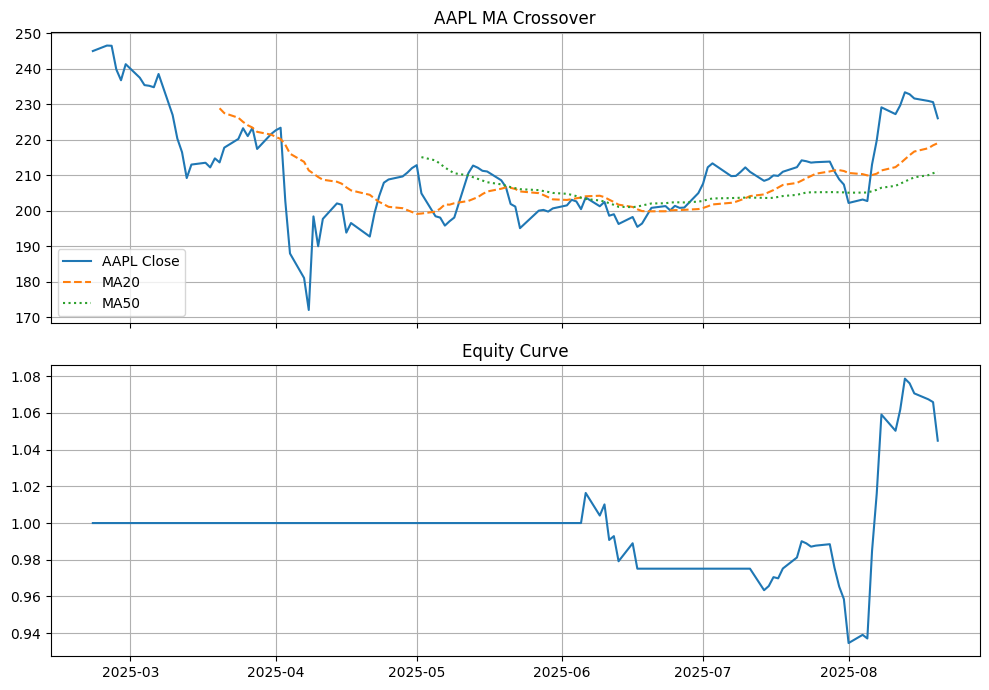

In [1]:
# ===== Minimal end-to-end sanity block =====
import warnings

warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt


def load_close_prices(tickers, period="6mo", interval="1d"):
    df = yf.download(
        tickers,
        period=period,
        interval=interval,
        auto_adjust=True,
        progress=False,
        group_by="column",
    )
    # Handle single vs multi-ticker shapes from yfinance
    if isinstance(df.columns, pd.MultiIndex):
        lvl0 = df.columns.get_level_values(0)
        field = "Adj Close" if "Adj Close" in lvl0 else "Close"
        close = df[field]
        close = close.reindex(columns=[t for t in tickers if t in close.columns])
    else:
        if "Adj Close" in df.columns:
            close = df["Adj Close"].to_frame(tickers[0])
        elif "Close" in df.columns:
            close = df["Close"].to_frame(tickers[0])
        else:
            raise KeyError("未找到 Close/Adj Close 欄位")
    return close.dropna(how="all")


def backtest(close, ma_short=20, ma_long=50):
    """Single-series MA crossover backtest (long/flat)."""
    daily_ret = close.pct_change().fillna(0)
    ma_s = close.rolling(ma_short).mean()
    ma_l = close.rolling(ma_long).mean()
    signal = (ma_s > ma_l).astype(int)  # 1 long / 0 flat
    pos = signal.shift(1).fillna(0)  # trade next day open
    strat_ret = pos * daily_ret
    equity = (1 + strat_ret).cumprod()
    return pd.DataFrame(
        {
            "Close": close,
            "MA_Short": ma_s,
            "MA_Long": ma_l,
            "Signal": signal,
            "Position": pos,
            "DailyRet": strat_ret,
            "Equity": equity,
        }
    )


def perf_stats(eq, daily_ret):
    n = len(eq)
    stats = {
        "CumReturn": (eq.iloc[-1] / eq.iloc[0]) - 1,
        "CAGR": (eq.iloc[-1] / eq.iloc[0]) ** (252.0 / max(1, n)) - 1,
        "AnnVol": daily_ret.std() * np.sqrt(252.0),
        "Sharpe": 0.0
        if daily_ret.std() == 0
        else daily_ret.mean() / daily_ret.std() * np.sqrt(252.0),
        "MaxDD": ((eq / eq.cummax()) - 1).min(),
        "HitRate": (daily_ret > 0).sum() / max(1, (daily_ret != 0).sum()),
    }
    return stats


def generate_signals(prices):
    """NEW signature: only `prices`. MAs/RSI computed inside."""
    signals = pd.DataFrame(index=prices.index)
    for ticker in prices.columns:
        s = prices[ticker]
        ma20 = s.rolling(20).mean()
        ma50 = s.rolling(50).mean()
        # RSI(14) simple version
        d = s.diff()
        gain = d.clip(lower=0).rolling(14).mean()
        loss = (-d.clip(upper=0)).rolling(14).mean()
        rs = gain / loss
        rsi14 = 100 - (100 / (1 + rs))
        sig = pd.Series(0, index=s.index, dtype=int)
        sig[ma20 > ma50] = 1
        sig[ma20 < ma50] = -1
        # (可選) 例：sig[(ma20 > ma50) & (rsi14 > 30)] = 1
        signals[ticker] = sig
    return signals


# ===== Driver =====
TICKERS = ["AAPL", "MSFT", "GOOG", "TSLA"]
prices = load_close_prices(TICKERS, "6mo", "1d")
print(prices.shape, list(prices.columns)[:5])

# Use one ticker for the simple MA backtest
pick = TICKERS[0]
close = prices[pick]
bt = backtest(close)

# build signals (for all tickers) just to prove the signature is (prices)
sigs = generate_signals(prices)
print("generate_signals signature OK; columns:", list(sigs.columns))

# quick stats and plot
stats = perf_stats(bt["Equity"], bt["DailyRet"])
print(stats)

fig, ax = plt.subplots(2, 1, figsize=(10, 7), sharex=True)
ax[0].plot(bt.index, bt["Close"], label=f"{pick} Close")
ax[0].plot(bt.index, bt["MA_Short"], label="MA20", linestyle="--")
ax[0].plot(bt.index, bt["MA_Long"], label="MA50", linestyle=":")
ax[0].legend()
ax[0].grid(True)
ax[0].set_title(f"{pick} MA Crossover")

ax[1].plot(bt.index, bt["Equity"])
ax[1].set_title("Equity Curve")
ax[1].grid(True)
plt.tight_layout()
plt.show()